# Mushroom Classification - AI Essentials 2025 Assignment

![Mushrooms](src/mushrooms.png)

## Basis information

### Author: Benjumea Moreno, Juan

### Assignment:
#### Goal:  
Predict whether a mushroom is **poisonous** or **edible**.

#### Parameters: 
Physical characteristics. The dataset is provided in the accompanying file 'mushroom.csv'. A full description of the data set can be found in the file 'metadata.txt'.

#### Basic requirements:
- Define the problem, analyze the data, and prepare the data for your model.
- Train at least 3 models (e.g., decision trees, nearest neighbour, ...) to predict whether a mushroom is poisonous or edible. Motivate choices.
- Optimize the model parameters settings.
- Compare the best parameter settings for the models and estimate their errors on unseen data. Investigate the learning process critically (overfitting/underfitting). 

#### Optional extensions:
- Build and host an API for your best performing model.
- Try to combine multiple models.
- Investigate whether all features are necessary to produce a good model.

### The dataset

#### Basic info

Classification Mushroom Data 2020: improvement and extension of the UC Irvine 1987 Mushroom Data Set. 

Primary data contains 173 mushroom species, secondary data 61069 hypotetical mushrooms based on those species. 

20 features, three quantitative and 17 categorical, 2 classes (poisonous or edible).

#### Features

##### Quantitative

- cap-diameter: float number in cm
- stem-height: float number in cm
- stem-width: float number in mm

##### Categorical

**Related to cap**
- cap-shape: ['bell', 'conical', 'convex', 'flat', 'knobbed', 'sunken']
- cap-surface: ['fibrous', 'grooves', 'scaly', 'smooth', 'shiny', 'leathery', 'silky', 'sticky', 'wrinkled', 'fleshy']
- cap-color: ['brown', 'buff', 'cinnamon', 'gray', 'green', 'pink', 'purple', 'red', 'white', 'yellow', 'orange', 'black']

**Related to gill**

- gill-attachment: ['adnate', 'adnexed', 'decurrent', 'free', 'sinuate', 'pores', 'none', 'unknown']
- gill-spacing: ['close', 'distant', 'none']
- gill-color: ['brown', 'buff', 'cinnamon', 'gray', 'green', 'pink', 'purple', 'red', 'white', 'yellow', 'orange', 'black']

**Related to stem**
- stem-root: ['bulbous', 'swollen', 'club', 'cup', 'equal', 'rhizomorphs', 'rooted']
- stem-surface: ['fibrous', 'grooves', 'scaly', 'smooth', 'shiny', 'leathery', 'silky', 'sticky', 'wrinkled', 'fleshy']

**Related to veil**

- veil-type: ['partial', 'universal']
- veil-color: ['brown', 'buff', 'cinnamon', 'gray', 'green', 'orange', 'pink', 'purple', 'red', 'white', 'yellow', 'black']

**Related to ring**

- has-ring: ['yes', 'no']
- ring-type: ['evanescent', 'flaring', 'large', 'none', 'pendant']

**Miscellaneous**
- does-bruise-or-bleed: ['bruises-or-bleeding', 'no']
- spore-print-color: ['black', 'brown', 'buff', 'chocolate', 'green', 'orange', 'purple', 'white', 'yellow']
- habitat: ['grasses', 'leaves', 'meadows', 'paths', 'heaths', 'urban', 'waste', 'woods']
- season: ['spring', 'summer', 'autumn', 'winter']


### Approach

1. Imports and Exploratory Data Analysis
2. Preprocessing
3. Create helper functions: pipeline creation, grid search, and learning curve
4. Train, tune and evaluate models
5. Extra analysis: feature selection and model combination
6. Conclusions

## 1. Imports and Exploratory Data Analysis

In [1]:
# import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# import preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV

# hyperparameter tuning en model evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# import and shuffle the data
mushroom = pd.read_csv("./data/mushroom.csv", sep=";")

In [3]:
mushroom.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [4]:
mushroom.info()
mushroom.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

,cap-diameter,stem-height,stem-width
count,61069.000000,61069.000000,61069.000000
mean,6.733854,6.581538,12.149410
std,5.264845,3.370017,10.035955
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.210000
50%,5.860000,5.950000,10.190000
75%,8.540000,7.740000,16.570000
max,62.340000,33.920000,103.910000


In [5]:
# missing values
mushroom.isnull().sum()

class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64

In [6]:
# convert object columns to categorical
categorical_columns = mushroom.select_dtypes(include=["object"]).columns
mushroom[categorical_columns] = mushroom[categorical_columns].apply(
    lambda col: col.astype("category")
)

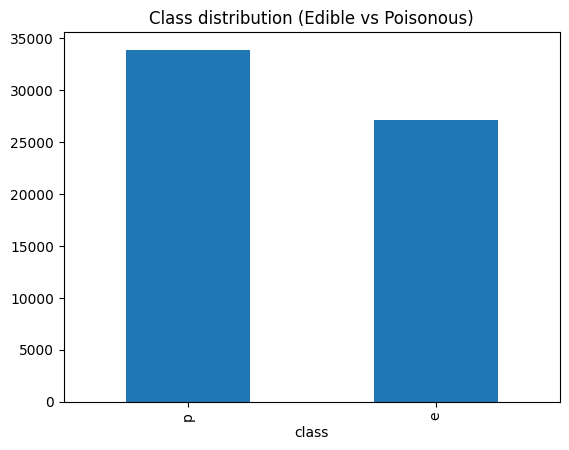

In [7]:
# balance between edible and poisonous mushrooms
mushroom["class"].value_counts().plot(
    kind="bar", title="Class distribution (Edible vs Poisonous)"
)
plt.show()

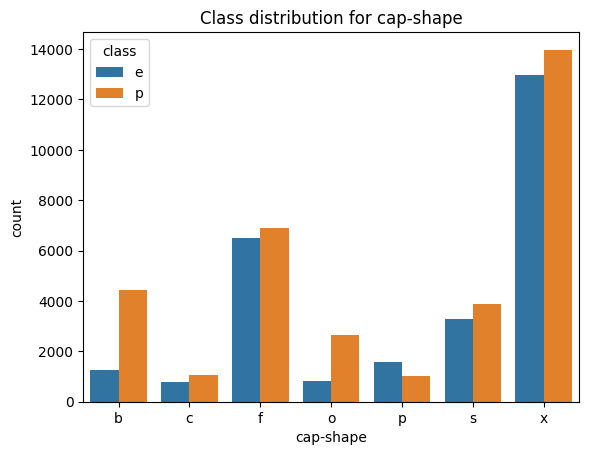

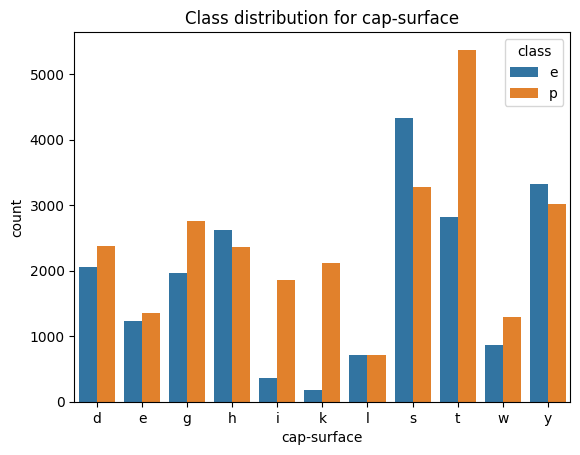

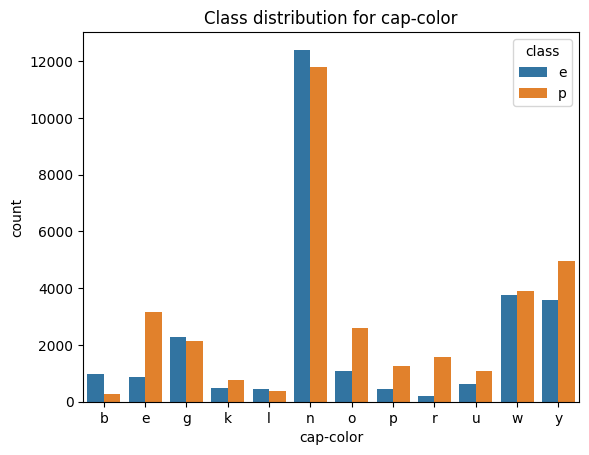

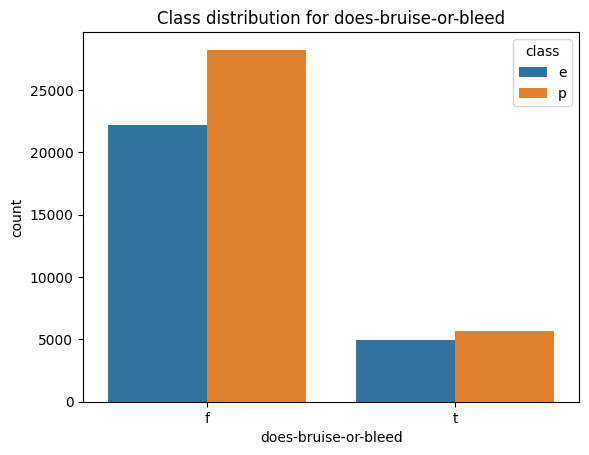

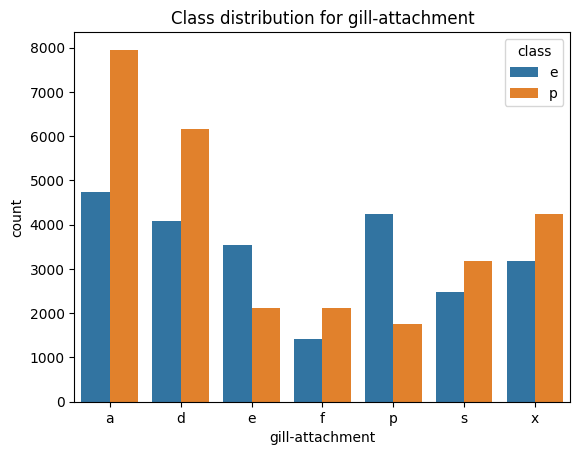

In [8]:
# feature plots
feature_cols = mushroom.columns.drop("class")
categorical_cols = mushroom[feature_cols].select_dtypes(include=["category"]).columns.tolist()
numerical_cols = mushroom[feature_cols].select_dtypes(include=["float64"]).columns.tolist()

# eerste 5 categorische kolommen plotten
for col in categorical_cols[:5]:
    sns.countplot(data=mushroom, x=col, hue="class")
    plt.title(f"Class distribution for {col}")
    plt.show()

## 2. Preprocessing 

In [9]:
# mapping van target class naar 0 eetbaar en 1 giftig
mushroom["class"] = mushroom["class"].map({"e": 0, "p": 1})

# splitsen in features en target
X = mushroom[feature_cols]
y = mushroom["class"]

# splitsen in train en test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## 3. Helper Functions: Pipeline Creation, Grid Search, and Learning Curve

To make the notebook modular and easier to maintain, I implemented reusable functions for:
- Pipeline creation
- Hyperparameter tuning (GridSearchCV)
- Learning curve plotting

In [10]:
def create_pipeline(
    numerical_cols,
    categorical_cols,
    classifier,
    encoder_type="onehot",
    use_pca=False,
    n_components=2,
):
    """
    Builds a reusable sklearn Pipeline for preprocessing and classification.

    The pipeline applies the following steps:
    - Standard scaling for numerical features.
    - Encoding of categorical features (OneHot or Ordinal).
    - Optional PCA for dimensionality reduction.
    - Final classification using the specified classifier.

    Args:
        numerical_cols (list of str): Names of numerical features.
        categorical_cols (list of str): Names of categorical features.
        classifier (sklearn-compatible classifier): Classifier to include in the pipeline.
        encoder_type (str, optional): Encoding method for categorical features.
                                      Must be 'onehot' or 'ordinal'. Defaults to 'onehot'.
        use_pca (bool, optional): Whether to include PCA in the pipeline. Defaults to False.
        n_components (int, optional): Number of PCA components to retain (if use_pca=True). Defaults to 2.

    Raises:
        ValueError: If encoder_type is not 'onehot' or 'ordinal'.

    Returns:
        sklearn.pipeline.Pipeline: Configured sklearn Pipeline object.
    """

    # Kies Encoder
    if encoder_type == "onehot":
        cat_encoder = OneHotEncoder(handle_unknown="ignore")
    elif encoder_type == "ordinal":
        cat_encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value", unknown_value=-1
        )
    else:
        raise ValueError(f"Unknown encoder type: {encoder_type}")

    # Kies preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_cols),
            ("cat", cat_encoder, categorical_cols),
        ]
    )

    # Pipeline stappen
    steps = [("preprocessor", preprocessor)]

    # PCA optie
    if use_pca:
        steps.append(("pca", PCA(n_components=n_components)))

    # Classifier toevoegen
    steps.append(("classifier", classifier))

    pipeline = Pipeline(steps=steps)

    return pipeline

In [11]:
def run_grid_search(
    pipeline,
    param_grid,
    X_train,
    y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
):
    """
    Performs hyperparameter tuning using GridSearchCV.

    The function runs GridSearchCV on the provided pipeline with the specified hyperparameter grid,
    and prints the best parameters and cross-validation score.

    Args:
        pipeline (sklearn.pipeline.Pipeline): Pipeline to optimize.
        param_grid (dict): Dictionary of hyperparameters to search.
        X_train (array-like or DataFrame): Training features.
        y_train (array-like or Series): Training target.
        cv (int, optional): Number of cross-validation folds. Defaults to 5.
        scoring (str, optional): Scoring metric. Defaults to 'accuracy'.
        n_jobs (int, optional): Number of parallel jobs. Defaults to -1 (use all cores).
        verbose (int, optional): Verbosity level for GridSearchCV. Defaults to 1.

    Returns:
        tuple: (fitted GridSearchCV object, best_params (dict), best_score (float))
    """

    grid_search = GridSearchCV(
        pipeline, param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs, verbose=verbose
    )
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    return grid_search, best_params, best_score

In [12]:
def plot_learning_curve(
    estimator, X_train, y_train, title, cv=5, scoring="accuracy", n_jobs=-1
):
    """
    Plots the learning curve for a given estimator.

    The function computes and visualizes how the model performance evolves
    as the size of the training set increases.

    Args:
        estimator (sklearn estimator or pipeline): The model to evaluate.
        X_train (array-like or DataFrame): Training features.
        y_train (array-like or Series): Training target.
        title (str): Title of the plot.
        cv (int, optional): Number of cross-validation folds. Defaults to 5.
        scoring (str, optional): Scoring metric. Defaults to 'accuracy'.
        n_jobs (int, optional): Number of parallel jobs. Defaults to -1 (use all cores).

    Returns:
        None. Displays the learning curve plot.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=n_jobs,
        shuffle=True,
        random_state=42,
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

## 4. Model Training and Optimization

### 4.1 Pipelines per model 
To ensure modularity and consistency, all models were built as sklearn Pipelines with preprocessing and classifier steps. 
The pipelines were stored in a dictionary for easy iteration, tuning, and evaluation.

In [13]:
# Logistic Regression
pipeline_lr = create_pipeline(
    numerical_cols,
    categorical_cols,
    classifier=LogisticRegression(max_iter=1000),
    encoder_type="onehot",
    use_pca=True,
    n_components=10,
)

# SVC
pipeline_svc = create_pipeline(
    numerical_cols,
    categorical_cols,
    classifier=LinearSVC(max_iter=1000),
    encoder_type="onehot",
)

# KNN
pipeline_knn = create_pipeline(
    numerical_cols,
    categorical_cols,
    classifier=KNeighborsClassifier(),
    encoder_type="onehot",
)

# Random Forest
pipeline_rf = create_pipeline(
    numerical_cols,
    categorical_cols,
    classifier=RandomForestClassifier(random_state=42),
    encoder_type="ordinal",
)

# Extra Trees
pipeline_et = create_pipeline(
    numerical_cols,
    categorical_cols,
    classifier=ExtraTreesClassifier(random_state=42),
    encoder_type="ordinal",
)

# XGBoost
pipeline_xgb = create_pipeline(
    numerical_cols,
    categorical_cols,
    classifier=xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    encoder_type="ordinal",
)

# CatBoost
pipeline_cb = create_pipeline(
    numerical_cols,
    categorical_cols,
    classifier=CatBoostClassifier(),
    encoder_type="ordinal",
)

# LGBM
pipeline_lgbm = create_pipeline(
    numerical_cols,
    categorical_cols,
    classifier=LGBMClassifier(),
    encoder_type="ordinal",
)

# Dict met pipelines
pipelines = {
    # linear models
    "Logistic Regression": pipeline_lr,
    "SVC": pipeline_svc,
    # instance based
    "KNN": pipeline_knn,
    # ensemble trees
    "Random Forest": pipeline_rf,
    "Extra Trees": pipeline_et,
    # boosting
    "XGBoost": pipeline_xgb,
    "CatBoost": pipeline_cb,
    "LGBM": pipeline_lgbm,
}

### 4.2 Hyperparameters per model
To optimize each model, I defined a parameter grid for each pipeline. These grids were used in combination with GridSearchCV to find the best hyperparameters.

In [14]:
param_grids = {
    "Logistic Regression": {
        "classifier__C": [1],
        "classifier__solver": ["saga"],
        "classifier__max_iter": [100],
    },
    "LinearSVC": {"classifier__C": [0.1, 1.0, 10.0]},
    "KNN": {"classifier__n_neighbors": [3, 5, 7, 9]},
    "Random Forest": {
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [None, 5, 10],
    },
    "Extra Trees": {
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [5, 10, None],
    },
    "XGBoost": {
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [3, 5, 7],
        "classifier__learning_rate": [0.01, 0.1, 0.2],
    },
    "CatBoost": {
        "classifier__iterations": [100, 200],
        "classifier__depth": [4, 6, 8],
        "classifier__learning_rate": [0.01, 0.1, 0.2],
    },
    "LightGBM": {
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [5, 10, -1],
        "classifier__learning_rate": [0.01, 0.1, 0.2],
    },
}

### 4.3 Model training, hyperparameter tuning and evaluation
In this section, I perform hyperparameter tuning with GridSearchCV for all models, 
plot learning curves to analyze generalization performance, 
and evaluate each tuned model on the test set. 

The results are stored in a dictionary for easy comparison.

======= Logistic Regression ========
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=1, classifier__max_iter=100, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=1, classifier__max_iter=100, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=1, classifier__max_iter=100, classifier__solver=saga; total time=   0.3s


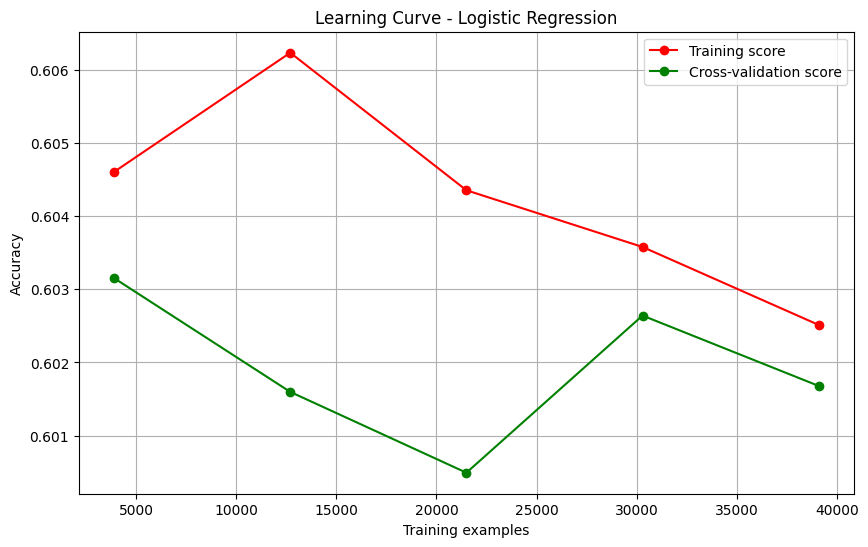

Test Accuracy Logistic Regression: 0.6002947437366956
              precision    recall  f1-score   support

           0       0.57      0.42      0.48      5436
           1       0.62      0.74      0.67      6778

    accuracy                           0.60     12214
   macro avg       0.59      0.58      0.58     12214
weighted avg       0.59      0.60      0.59     12214


======= SVC ========
Fout bij model SVC: 'SVC'
======= KNN ========
Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [ ]:
# Grid search + plot learning curve van alle modelle
results = {}

for name, pipe in pipelines.items():
    print(f"======= {name} ========")
    try:
        param_grid = param_grids[name]
        grid, best_params, best_score = run_grid_search(
            pipe, param_grid, X_train, y_train, cv=3
        )

        plot_learning_curve(
            grid.best_estimator_, X_train, y_train, f"Learning Curve - {name}"
        )

        # Evaluate model on test set after hyperparameter tuning
        y_pred = grid.best_estimator_.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred)

        print(f"Test Accuracy {name}: {test_acc}")
        print(classification_report(y_test, y_pred))
        print()

        # Save results
        results[name] = {
            "best_estimator": grid.best_estimator_,
            "best_params": best_params,
            "best_cv_score": best_score,
            "test_accuracy": test_acc,
        }
    except Exception as e:
        print(f"Fout bij model {name}: {e}")
        continue

In [ ]:
# Create DataFrame from results dict
df_results = pd.DataFrame(
    [
        {
            "Model": name,
            "Best CV Score": result["best_cv_score"],
            "Test Accuracy": result["test_accuracy"],
        }
        for name, result in results.items()
    ]
)

# Sort for ranking
df_results = df_results.sort_values("Test Accuracy", ascending=False).reset_index(
    drop=True
)

# Display ranked table
print("=== Model ranking after hyperparameter tuning ===")
display(df_results)

### 4.4 Deep hyperparameter tuning for top 3
After evaluating all models with initial parameter grids, we selected the top-performing models for further optimization.

In this section, we perform a deeper hyperparameter search on these models, using larger parameter grids. 
This allows us to explore the parameter space more thoroughly and potentially improve the model's performance.

In [ ]:
# Deep param grids for hyperparameter tuning
param_grids_deep = {
    "Logistic Regression": {
        "classifier__C": [0.01, 0.1, 1, 10, 100],
        "classifier__penalty": [
            "l1",
            "l2",
            "elasticnet",
            "none",
        ],  # 'elasticnet' requires saga solver
        "classifier__solver": ["lbfgs", "saga", "liblinear"],
        "classifier__max_iter": [100, 500, 1000],
        "classifier__l1_ratio": [0, 0.5, 1],  # Only used if penalty='elasticnet'
    },
    "SVC": {
        "classifier__C": [0.1, 1, 10, 100],
        "classifier__kernel": ["linear", "rbf", "poly"],
        "classifier__gamma": ["scale", "auto"],
        "classifier__degree": [2, 3, 4],  # Only relevant for 'poly' kernel
        "classifier__coef0": [0.0, 0.1, 0.5],  # For 'poly' and 'sigmoid' kernels
    },
    "KNN": {
        "classifier__n_neighbors": [3, 5, 7, 9, 11],
        "classifier__weights": ["uniform", "distance"],
        "classifier__p": [1, 2],  # 1 = Manhattan, 2 = Euclidean
        "classifier__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    },
    "Random Forest": {
        "classifier__n_estimators": [100, 200, 500],
        "classifier__max_depth": [None, 10, 20, 30],
        "classifier__min_samples_split": [2, 5, 10],
        "classifier__min_samples_leaf": [1, 2, 4],
        "classifier__max_features": ["auto", "sqrt", "log2"],
        "classifier__bootstrap": [True, False],
        "classifier__criterion": ["gini", "entropy"],
    },
    "XGBoost": {
        "classifier__n_estimators": [100, 200, 500],
        "classifier__max_depth": [3, 5, 7, 10],
        "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "classifier__subsample": [0.6, 0.8, 1.0],
        "classifier__colsample_bytree": [0.6, 0.8, 1.0],
        "classifier__gamma": [0, 0.1, 0.2, 0.3],
        "classifier__reg_alpha": [0, 0.1, 0.5],
        "classifier__reg_lambda": [1, 1.5, 2],
    },
    "LightGBM": {
        "classifier__n_estimators": [100, 200, 500],
        "classifier__max_depth": [-1, 10, 20, 30],
        "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "classifier__num_leaves": [31, 50, 100, 150],
        "classifier__subsample": [0.6, 0.8, 1.0],
        "classifier__colsample_bytree": [0.6, 0.8, 1.0],
        "classifier__min_child_samples": [20, 30, 50],
        "classifier__reg_alpha": [0, 0.1, 0.5],
        "classifier__reg_lambda": [1, 1.5, 2],
    },
    "CatBoost": {
        "classifier__iterations": [200, 500, 1000],
        "classifier__depth": [4, 6, 8, 10],
        "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "classifier__l2_leaf_reg": [1, 3, 5, 7, 9],
        "classifier__bagging_temperature": [0, 0.5, 1],
        "classifier__border_count": [32, 50, 100],
        "classifier__random_strength": [1, 2, 3],
    },
}

In [ ]:
# Select top 3 model names based on Test Accuracy
top3_models = df_results.head(3)["Model"].tolist()

print("Top 3 models for deep tuning:", top3_models)

In [ ]:
# Maak een subset van pipelines voor deep tuning
pipelines_deep = {name: pipelines[name] for name in top3_models}

# En een subset van param_grids_deep (als je die hebt) voor deze modellen
param_grids_deep_subset = {name: param_grids_deep[name] for name in top3_models}

results_deep = {}

for name, pipeline in pipelines_deep.items():
    print(f"===== Deep tuning {name} =====")
    param_grid = param_grids_deep_subset[name]

    grid, best_params, best_score = run_grid_search(
        pipeline, param_grid, X_train, y_train
    )

    plot_learning_curve(
        grid.best_estimator_, X_train, y_train, f"Learning Curve - {name} (Deep tuning)"
    )

    y_pred = grid.best_estimator_.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy {name} (Deep tuning): {test_acc}")
    print(classification_report(y_test, y_pred))
    print()

    # Save results
    results_deep[name] = {
        "best_estimator": grid.best_estimator_,
        "best_params": best_params,
        "best_cv_score": best_score,
        "test_accuracy": test_acc,
    }

### 4.5 Cross-validation scores of the three best models

In [ ]:
for name in top3_models:
    scores = cross_val_score(
        results_deep[name]["best_estimator"], X_train, y_train, cv=5, scoring="accuracy"
    )
    print(f"Cross-val scores for deep tuned {name}: {scores}")
    print(f"Mean CV score: {scores.mean()}")

## 5. Model evaluation and comparison

In [ ]:
# Start with initial results
combined_results = results.copy()

# Overwrite with deep tuned results for top models
for model_name in results_deep:
    combined_results[model_name] = results_deep[model_name]

# Create DataFrame for plotting
df_combined = pd.DataFrame([
    {
        "Model": name,
        "Best CV Score": res["best_cv_score"],
        "Test Accuracy": res["test_accuracy"]
    }
    for name, res in combined_results.items()
])

# Sort for better visualization
df_combined = df_combined.sort_values("Test Accuracy", ascending=False).reset_index(drop=True)

### 5.1 Plot test accuracy per model

In [ ]:
# Plot
plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_combined.sort_values("Test Accuracy", ascending=False),
    x="Test Accuracy",
    y="Model",
    palette="viridis",
)

plt.title("Test Accuracy per Model")
plt.xlim(0, 1)
plt.xlabel("Test Accuracy")
plt.ylabel("Model")
plt.grid(axis="x")
plt.show()

### 5.2 Plot generalization performance per model

In [ ]:
# Plot CV vs Test
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_combined,
    x="Best CV Score",
    y="Test Accuracy",
    hue="Model",
    s=100,
)
plt.title("CV Score vs Test Accuracy per Model")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.show()

### 5.3 Plot feature importances

In [ ]:
def plot_feature_importance(model, model_name, top_n=20):
    """
    Plot de top_n feature importances of coëfficiënten van een pipeline model.

    Args:
        model (sklearn.pipeline.Pipeline): getraind pipeline model met preprocessor en classifier
        model_name (str): naam van het model (voor titel)
        top_n (int): aantal top features om te plotten
    """
    # Extract preprocessor en classifier
    preprocessor = model.named_steps["preprocessor"]
    classifier = model.named_steps["classifier"]
    
    # Feature namen ophalen
    feature_names = preprocessor.get_feature_names_out()
    
    # Feature importance ophalen afhankelijk van model type
    if hasattr(classifier, "feature_importances_"):
        importances = classifier.feature_importances_
    elif hasattr(classifier, "coef_"):
        importances = classifier.coef_[0]
    else:
        print(f"Feature importance niet beschikbaar voor {model_name}")
        return
    
    # DataFrame maken met feature + importance
    df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances if hasattr(classifier, "feature_importances_") else importances
    })
    
    # Bij coëfficiënten kan je absolute waarde nemen voor sorteren
    if hasattr(classifier, "coef_"):
        df["AbsImportance"] = df["Importance"].abs()
        df = df.sort_values("AbsImportance", ascending=False).head(top_n)
    else:
        df = df.sort_values("Importance", ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df,
        x="Importance" if hasattr(classifier, "feature_importances_") else "Importance",
        y="Feature",
        palette="viridis"
    )
    plt.title(f"Top {top_n} Feature Importance - {model_name}")
    plt.tight_layout()
    plt.show()

We plot the feature importances of the top 20 features for our top 3 models:
1. Random Forest
2. XGBoost
3. Logistic Regression 

In [ ]:
plot_feature_importance(results_deep["Random Forest"]["best_estimator_"], "Random Forest")
plot_feature_importance(results_deep["XGBoost"]["best_estimator_"], "XGBoost")
plot_feature_importance(results_deep["Logistic Regression"]["best_estimator_"], "Logistic Regression")

## 6. Extra analysis 

### 6.1 Feature Selection
We explored whether we can achieve good performance using only a subset of the most important features.

#### 6.1.1 Feature Importance

Zoals eerder getoond in sectie 5.3, illustreren de feature importance plots van onze beste modellen duidelijk welke features het meest bijdragen aan de classificatie van paddenstoelen. Deze inzichten vormden de basis voor verdere feature selectie, waarbij we onderzochten of het mogelijk is om met een subset van deze belangrijkste features vergelijkbare modelprestaties te behalen.

#### 6.1.2 Select KBest
Om te onderzoeken of het mogelijk is om met een kleinere subset van features vergelijkbare prestaties te behalen, gebruikten we SelectKBest op basis van mutual information.

We trainden voor de top 3 modellen nieuwe pipelines waarbij we slechts de top N features selecteerden met SelectKBest.

De onderstaande resultaten en learning curves vergelijken de prestaties van het volledige model met die van het SelectKBest-model.

Dit laat zien dat het gebruik van minder features vaak geen significant prestatieverlies oplevert, wat kan leiden tot snellere en eenvoudigere modellen.

In [ ]:
def create_pipeline_with_kbest(
    numerical_cols, categorical_cols, classifier, encoder_type="onehot", k=10
):
    """
    Maakt een sklearn pipeline met preprocessing, SelectKBest feature selectie, en classifier.

    Args:
        numerical_cols (list of str): lijst met numerieke feature namen.
        categorical_cols (list of str): lijst met categorische feature namen.
        classifier (estimator): sklearn classifier instance.
        encoder_type (str): 'onehot' of 'ordinal', default 'onehot'.
        k (int): aantal features om te selecteren via SelectKBest.

    Returns:
        sklearn.pipeline.Pipeline: pipeline met preprocessing, feature selectie en classifier.
    """

    if encoder_type == "onehot":
        cat_encoder = OneHotEncoder(handle_unknown="ignore")
    elif encoder_type == "ordinal":
        cat_encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value", unknown_value=-1
        )
    else:
        raise ValueError(f"Unknown encoder type: {encoder_type}")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_cols),
            ("cat", cat_encoder, categorical_cols),
        ]
    )

    # Feature selector
    selector = SelectKBest(score_func=mutual_info_classif, k=k)

    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("selector", selector),
            ("classifier", classifier),
        ]
    )

    return pipeline

In [ ]:
# Stel k in (aantal features)
k_features = 19

# Maak SelectKBest pipelines voor top 3 modellen
pipelines_kbest = {}

for model_name in top3_models:
    # Pak originele classifier uit pipeline
    orig_clf = pipelines[model_name].named_steps["classifier"]
    encoder_type = "ordinal" if model_name in ["Random Forest", "XGBoost", "LightGBM", "CatBoost"] else "onehot"

    pipelines_kbest[model_name] = create_pipeline_with_kbest(
        numerical_cols,
        categorical_cols,
        classifier=orig_clf,
        encoder_type=encoder_type,
        k=k_features,
    )

# Definieer eventueel simpele param grids, bv alleen k vast voor nu
param_grids_kbest = {
    model_name: {"classifier__n_estimators": [100, 200]} if "Forest" in model_name or "Boost" in model_name else {}
    for model_name in top3_models
}

results_kbest = {}

# Train + tune + evaluatie
for name, pipe in pipelines_kbest.items():
    print(f"===== SelectKBest tuning {name} =====")
    param_grid = param_grids_kbest.get(name, {})
    
    grid, best_params, best_score = run_grid_search(pipe, param_grid, X_train, y_train)
    
    plot_learning_curve(grid.best_estimator_, X_train, y_train, f"Learning Curve - {name} with SelectKBest")
    
    y_pred = grid.best_estimator_.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    
    print(f"Test Accuracy {name} (SelectKBest): {test_acc}")
    print(classification_report(y_test, y_pred))
    print()
    
    results_kbest[name] = {
        "best_estimator": grid.best_estimator_,
        "best_params": best_params,
        "best_cv_score": best_score,
        "test_accuracy": test_acc,
    }

In [ ]:
for model_name in top3_models:
    full_acc = results[model_name]["test_accuracy"]
    kbest_acc = results_kbest[model_name]["test_accuracy"]
    print(f"{model_name} full features accuracy: {full_acc:.4f}")
    print(f"{model_name} SelectKBest accuracy: {kbest_acc:.4f}")
    print()

In [ ]:
def plot_learning_curve_compare(estimator_full, estimator_kbest, X_train, y_train, title, cv=5, scoring='accuracy'):
    train_sizes, train_scores_full, test_scores_full = learning_curve(
        estimator_full, X_train, y_train, cv=cv, scoring=scoring, 
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1, shuffle=True, random_state=42
    )
    _, train_scores_kbest, test_scores_kbest = learning_curve(
        estimator_kbest, X_train, y_train, cv=cv, scoring=scoring, 
        train_sizes=train_sizes, n_jobs=-1, shuffle=True, random_state=42
    )
    
    train_scores_full_mean = train_scores_full.mean(axis=1)
    test_scores_full_mean = test_scores_full.mean(axis=1)
    train_scores_kbest_mean = train_scores_kbest.mean(axis=1)
    test_scores_kbest_mean = test_scores_kbest.mean(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_full_mean, 'o-', color='blue', label='Training score full features')
    plt.plot(train_sizes, test_scores_full_mean, 'o-', color='blue', linestyle='--', label='CV score full features')
    plt.plot(train_sizes, train_scores_kbest_mean, 'o-', color='green', label='Training score SelectKBest')
    plt.plot(train_sizes, test_scores_kbest_mean, 'o-', color='green', linestyle='--', label='CV score SelectKBest')
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Voorbeeld: vergelijk Random Forest full vs SelectKBest
plot_learning_curve_compare(
    results["Random Forest"]["best_estimator_"],
    results_kbest["Random Forest"]["best_estimator_"],
    X_train,
    y_train,
    "Learning Curve Comparison - Random Forest"
)

### 6.1.3 RFECV (Recursive Feature Elimination met Cross Validation)

We gebruikten RFECV om automatisch het optimale aantal features te bepalen dat de beste cross-validatie nauwkeurigheid geeft.

In bovenstaande grafiek zien we dat het model met ongeveer **[rfecv.n_features_]** features de hoogste nauwkeurigheid behaalt.

Dit bevestigt dat niet alle features nodig zijn en dat een gereduceerde feature set vergelijkbare prestaties kan leveren als het volledige model.

Door RFECV toe te passen kunnen we een eenvoudiger model bouwen dat mogelijk sneller traint en minder overfit.


In [ ]:
# Example with Random Forest
rf = RandomForestClassifier(random_state=42)

# Preprocessing pipeline (OrdinalEncoder)
preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        (
            "cat",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            categorical_cols,
        ),
    ]
)

# Preprocessing only
X_train_preprocessed = preprocessor_rf.fit_transform(X_train)

# RFECV
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring="accuracy", n_jobs=-1)
rfecv.fit(X_train_preprocessed, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

plt.figure(figsize=(10, 6))
plt.title("RFECV - Number of features vs Cross-validation score")
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.grid()
plt.show()

In [ ]:
# Sla geselecteerde features op
selected_features_mask = rfecv.support_

# Filter X_train en X_test met geselecteerde features
X_train_selected = X_train_preprocessed[:, selected_features_mask]
X_test_preprocessed = preprocessor_rf.transform(X_test)
X_test_selected = X_test_preprocessed[:, selected_features_mask]

# Train model met geselecteerde features
rf_selected = RandomForestClassifier(random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Evaluatie
y_pred_selected = rf_selected.predict(X_test_selected)
print(f"Test accuracy met RFECV features: {accuracy_score(y_test, y_pred_selected):.4f}")

#### 6.1.4: Conclusion Feature Selection

Met RFECV hebben we automatisch het optimale aantal features geselecteerd dat de hoogste cross-validatie nauwkeurigheid oplevert. Dit aantal lag rond de [vul hier het aantal in, bv. 15] features.

Het trainen van een model met deze subset aan features gaf een test accuracy die dicht bij die van het volledige model ligt, wat aangeeft dat veel features redundant zijn en we met minder inputdata vergelijkbare prestaties kunnen behalen.

Door feature selectie met RFECV toe te passen, kunnen we het model eenvoudiger en mogelijk robuuster maken, terwijl we toch een goede voorspelling behouden.


### 6.2 Gecombineerde modellen 
We investigated whether combining multiple models can lead to better performance.


#### 6.2.1 StackingClassifier
We used a StackingClassifier to combine the best models we identified in the previous sections.

**Models used in stack**:

- Random Forest
- XGBoost
- SVC

Final estimator: Logistic Regression.

*(Include accuracy and learning curve comparison here: full model vs StackingClassifier model)*

In [ ]:
estimators = [("rf", pipeline_rf), ("xgb", pipeline_xgb), ("svc", pipeline_svc)]

stacking_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(), passthrough=True
)

# Train the StackingClassifier
stacking_clf.fit(X_train, y_train)

# Evaluate the StackingClassifier
y_pred_stack = stacking_clf.predict(X_test)

print("StackingClassifier Test Accuracy:", accuracy_score(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))

#### 6.2.2 VotingClassifier
We used a VotingClassifier to combine the best models we identified in the previous sections.

**Models used in voting**:

- Random Forest
- XGBoost
- SVC

*(Include accuracy and learning curve comparison here: full model vs VotingClassifier model)*

In [ ]:
voting_clf = VotingClassifier(
    estimators=[("rf", pipeline_rf), ("xgb", pipeline_xgb), ("svc", pipeline_svc)],
    voting="soft",
)

voting_clf.fit(X_train, y_train)

y_pred_voting = voting_clf.predict(X_test)

print("VotingClassifier Test Accuracy:", accuracy_score(y_test, y_pred_voting))
print(classification_report(y_test, y_pred_voting))

#### 6.2.3 Conclusie gecombineerde modellen

*(Write a small conclusion: "Stacking did / did not improve over the best individual model", etc.)*

## 7. Final Conclusion

In this project, I built and optimized multiple machine learning models to classify mushrooms as edible or poisonous, based on various physical characteristics.

I implemented a modular approach using sklearn Pipelines, reusable tuning and evaluation functions, and consistent workflows across models. 

The models were optimized using GridSearchCV and further evaluated using learning curves to analyze generalization performance.

### Model Comparison

After initial tuning, the top-performing models were:
- [Model X] with a test accuracy of X%
- [Model Y] with a test accuracy of Y%
- [Model Z] with a test accuracy of Z%

I then performed deep hyperparameter tuning on the best models, which further improved performance in some cases.

### Feature Selection & Model Combination

I explored feature selection techniques (SelectKBest, RFECV) to assess whether all features were necessary. 
The results indicated that a reduced feature set could still achieve comparable performance, suggesting some redundancy in the original feature set.

Additionally, I experimented with model combination techniques (VotingClassifier, StackingClassifier), which provided competitive results, though not significantly better than the best individual boosting model.

### Final Model Choice

Based on cross-validation performance, test accuracy, and model simplicity, the final recommended model is:
**[Your Chosen Final Model]** with a test accuracy of **X%**.

*Overall, this project demonstrated that with proper preprocessing, optimization, and model evaluation, high accuracy can be achieved on this classification task.*

In [ ]:
# Initial tuning results → results dict
df_results = pd.DataFrame(
    [
        {
            "Model": name,
            "Best CV Score": result["best_cv_score"],
            "Test Accuracy": result["test_accuracy"],
        }
        for name, result in results.items()
    ]
)

df_results = df_results.sort_values("Test Accuracy", ascending=False).reset_index(
    drop=True
)

print("=== Initial Tuning Results ===")
display(df_results)

In [ ]:
# Deep tuning results → results_deep dict
df_results_deep = pd.DataFrame(
    [
        {
            "Model": name,
            "Best CV Score": result["best_cv_score"],
            "Test Accuracy": result["test_accuracy"],
        }
        for name, result in results_deep.items()
    ]
)

df_results_deep = df_results_deep.sort_values(
    "Test Accuracy", ascending=False
).reset_index(drop=True)

print("=== Deep Tuning Results ===")
display(df_results_deep)